In [1]:
import os
os.chdir("..")

import torch
import torch.nn as nn
import numpy as np
from torch import optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchmetrics import MeanAbsolutePercentageError

from data.dataloader import dl_from_numpy, dataloader_info
from models.predictor import GRU
from utils.utils import load_yaml_config

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_prediction.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset info
dl_info_train = dataloader_info(configs)
dl_info_test = dataloader_info(configs, train=False)
dataset = dl_info_train['dataset']
seq_length, feature_dim = dataset.window, dataset.feature_dim
batch_size = configs["dataloader"]["batch_size"]
lr = 0.001

# Load data
ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"), batch_size=batch_size)
fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)
dl_test = dl_info_test["dataloader"]

In [3]:
# Model training function
def train_model(model, dataloader, criterion, optimizer, num_epochs=100, description=""):
    model.train()
    with tqdm(range(num_epochs), total=num_epochs) as pbar:
        for e in pbar:
            for data in dataloader:
                x_train = data[:,:-1,:].float().to(device)
                y_train = data[:,-1:,0].float().to(device)
                optimizer.zero_grad()
                outputs = model(x_train)
                loss = criterion(outputs, y_train)
                loss.backward()
                optimizer.step()
            pbar.set_description(f"{description} loss: {loss.item():.6f}")
    

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.optim import Adam
from tqdm.auto import tqdm
from models.predictor import GRU
from models.transformer import Transformer
from utils.utils import extract, cosine_beta_schedule, linear_beta_schedule
from einops import reduce, rearrange, repeat

class DiffusionTSAdversarial(nn.Module):
    def __init__(
            self,
            seq_length,
            n_feat,
            n_embd,
            timesteps,
            loss_type,
            beta_sch,
            n_heads,
            mlp_hidden_times,
            n_layer_enc,
            n_layer_dec,
            use_ff
    ):
        super().__init__()
        self.transformer = Transformer(n_feat=n_feat,
                                       seq_len=seq_length, 
                                       n_embd=n_embd,
                                       n_heads=n_heads, 
                                       mlp_hidden_times=mlp_hidden_times,
                                       n_layer_enc=n_layer_enc,
                                       n_layer_dec=n_layer_dec)
        self.timesteps = int(timesteps)
        self.loss_fn = F.l1_loss if loss_type == "l1" else F.l2_loss
        self.seq_length = seq_length
        self.n_feat = n_feat
        self.ff_weight = math.sqrt(self.seq_length) / 5
        self.use_ff = use_ff
        self.predictor = GRU(input_dim=n_feat,
                            hidden_dim=50,
                            output_dim=1,
                            num_layers=2)
        # To enhance computing performance
        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))

        # diffusion
        register_buffer('betas', cosine_beta_schedule(timesteps) if beta_sch=="cosine" else linear_beta_schedule(timesteps))
        register_buffer('alphas', 1. - self.betas)
        register_buffer('alphas_cumprod', torch.cumprod(self.alphas, dim=0))
        register_buffer('alphas_cumprod_prev', F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.))
        register_buffer('sqrt_alphas_cumprod', torch.sqrt(self.alphas_cumprod))
        register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1. - self.alphas_cumprod))
        
        # calculations for post q(x_{t-1} | x_t, x_0)
        register_buffer('posterior_variance', self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod))
        register_buffer('posterior_log_variance', torch.log(self.posterior_variance.clamp(min=1e-20)))
        register_buffer('posterior_mean_coef1', self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1. - self.alphas_cumprod))
        register_buffer('posterior_mean_coef2', (1. - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1. - self.alphas_cumprod))

        register_buffer('loss_weight', torch.sqrt(self.alphas) * torch.sqrt(1. - self.alphas_cumprod) / self.betas / 100)

        self.predictor_optimizer = Adam(self.predictor.parameters(), lr=0.001)
        self.predictor_lossfn = F.l1_loss

    def forward(self, x_0):
        batch, device = x_0.shape[0], x_0.device
        t = torch.randint(0, self.timesteps, (batch,), device=device).long()

        return self._train_loss(x_0=x_0, t=t)

    def predict_x_0(self, x_t, t):
        trend, season = self.transformer(x_t, t)
        x_0_hat = trend + season

        return x_0_hat

    def _train_loss(self, x_0, t):
        noise = torch.randn_like(x_0)
        x_t = self._forward_process(x_0=x_0, t=t, noise=noise)
        x_0_pred = self.predict_x_0(x_t, t)

        # l1 loss
        l1_loss = self.loss_fn(x_0_pred, x_0, reduction='none')

        # fourier_loss
        if self.use_ff:
            fourier_loss = torch.tensor([0.])
            fft1 = torch.fft.fft(x_0_pred.transpose(1, 2), norm='forward')
            fft2 = torch.fft.fft(x_0.transpose(1, 2), norm='forward')
            fft1, fft2 = fft1.transpose(1, 2), fft2.transpose(1, 2)
            fourier_real = self.loss_fn(torch.real(fft1), torch.real(fft2), reduction='none')
            fourier_img = self.loss_fn(torch.imag(fft1), torch.imag(fft2), reduction='none')
            fourier_loss = fourier_real + fourier_img

            combined_loss = l1_loss + self.ff_weight * fourier_loss
            combined_loss = reduce(combined_loss, 'b ... -> b (...)', 'mean')

        # adversarial loss
        pred = self.predictor(x_0_pred[:, :-1, :])
        target = x_0_pred[:, -1:, 0]
        adv_loss = self.loss_fn(pred, target, reduction="none")
        adv_weight = 0.001
        combined_loss = combined_loss - adv_weight * adv_loss
        combined_loss = combined_loss * extract(self.loss_weight, t, combined_loss.shape)

        return combined_loss.mean(), l1_loss.mean(), (self.ff_weight * fourier_loss).mean(), (adv_weight * adv_loss).mean()

    def _forward_process(self, x_0, t, noise):
        coef1 = extract(self.sqrt_alphas_cumprod, t, x_0.shape)
        coef2 = extract(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)
        x_t = coef1 * x_0 + coef2 * noise

        return x_t

    @torch.no_grad()
    def generate_mts(self, batch_size):
        device = self.betas.device
        shape = (batch_size, self.seq_length, self.n_feat)

        x_T = torch.randn(shape, device=device)
        synthetic_mts = self._reverse_process(x_T=x_T)

        return synthetic_mts.detach().cpu().numpy()

    def _reverse_process(self, x_T):
        desc = 'reverse step from x_T to x_0'
        for t in tqdm(reversed(range(0, self.timesteps)), total=self.timesteps, desc=desc):
            x_T = self._posterior_q(x_t=x_T, t=t)
        x_0_hat = x_T

        return x_0_hat

    def _posterior_q(self, x_t, t: int):
        '''posterior q(x_{t-1} | x_t, x_0)'''
        batched_t = torch.full((x_t.shape[0],), t, device=x_t.device, dtype=torch.long)
        x_0 = self.predict_x_0(x_t, t=batched_t)
        x_0.clamp_(min=-4., max=4.)

        post_mean = self._post_mean(x_0=x_0, x_t=x_t, t=batched_t)
        post_log_variance = self._post_log_var(t=batched_t, shape=x_t.shape)
        z = torch.randn_like(x_t) if t > 0 else 0.
        x_t_1 = post_mean + (0.5 * post_log_variance).exp() * z

        return x_t_1

    def _post_mean(self, x_0, x_t, t):
        coef1 = extract(self.posterior_mean_coef1, t, x_t.shape)
        coef2 = extract(self.posterior_mean_coef2, t, x_t.shape)
        post_mean = coef1 * x_0 + coef2 * x_t

        return post_mean

    def _post_log_var(self, t, shape):
        post_log_variance = extract(self.posterior_log_variance, t, shape)

        return post_log_variance

    def generate_adversarial(self, x_0, predictor, num_timesteps=10):
        batch, device = x_0.shape[0], x_0.device
        x_adv = x_0.clone()
        noise = torch.randn_like(x_adv)
        predictor.train()
        for _ in range(num_timesteps):
            # Forward process
            t = torch.randint(0, self.timesteps, (batch,), device=device).long()
            x_t = self._forward_process(x_adv, t, noise)
            x_t.requires_grad = True

            # Predict original
            x_0_hat = self.predict_x_0(x_t, t)
            # Predict using adversarial predictor
            pred = predictor(x_0_hat[:, :-1, :])

            target = x_0_hat[:, -1:, 0]
            loss = self.predictor_lossfn(pred, target)
            loss.backward()

            # Compute adversarial gradient
            grad = x_t.grad.data
            x_adv = (x_adv + 0.001 * grad.sign()).clamp(-4, 4).detach()
            # x_adv = (x_adv + 0.0005 * grad.sign()).clamp(-4, 4).detach()

        return x_adv
# Initialize Diffusion_TS Model
diffusion_adversarial = DiffusionTSAdversarial(
    seq_length=24, n_feat=5, n_embd=128, timesteps=1000,
    loss_type='l1', beta_sch='cosine',
    n_heads=8, mlp_hidden_times=4,
    n_layer_enc=1, n_layer_dec=4,
    use_ff=True
).to(device)

In [5]:
# Generate adversarial data
ori_data = torch.from_numpy(np.load('output/stock_ground_truth_data_24_train.npy')).to(device)
adv_data = diffusion_adversarial.generate_adversarial(ori_data,
                                                      predictor=diffusion_adversarial.predictor.to(device))

# Concatenate adversarial data with original data for training
combined_data = torch.cat([ori_data, adv_data], dim=0)
from torch.utils.data import DataLoader
combined_loader = DataLoader(combined_data, batch_size=128, shuffle=True)

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [6]:
import gc

# At the beginning or end of training
torch.cuda.empty_cache()
gc.collect()


11

In [7]:
# Train on original data
model_ori = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_ori = nn.L1Loss()
optimizer_ori = optim.Adam(model_ori.parameters(), lr=lr)
train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=2000, description="Original")

Original loss: 0.044517: 100%|██████████| 2000/2000 [00:49<00:00, 40.16it/s]


In [8]:
# Train on synthetic data
ori_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))).to(device)
fake_dataset = torch.from_numpy(np.load(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"))).to(device)
combined_dataset = torch.concatenate([ori_dataset,fake_dataset])
from torch.utils.data import DataLoader
ori_fake_dl = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)

model_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)
criterion_fake = nn.L1Loss()
optimizer_fake = optim.Adam(model_fake.parameters(), lr=lr)
train_model(model_fake, ori_fake_dl, criterion_fake, optimizer_fake, num_epochs=2000, description="Synthetic + Original")

Synthetic + Original loss: 0.026017: 100%|██████████| 2000/2000 [01:30<00:00, 22.11it/s]


In [9]:
# Train your GRU model using this combined data
model_ori_fake = GRU(input_dim=feature_dim, hidden_dim=50, num_layers=2).to(device)

criterion_ori_fake = nn.L1Loss()
optimizer_ori_fake = Adam(model_ori_fake.parameters(), lr=lr)
train_model(model_ori_fake, combined_loader, criterion_ori_fake, optimizer_ori_fake, num_epochs=2000, description="AdvSyn + Original")

AdvSyn + Original loss: 0.025441: 100%|██████████| 2000/2000 [01:30<00:00, 22.10it/s]


In [10]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Evaluate models on the test dataset
def evaluate_model(model, dataloader):
    model.eval()
    criterion = nn.L1Loss()
    criterion2 = nn.MSELoss()
    mapeloss = MeanAbsolutePercentageError().to(device)
    total_loss_L1 = 0
    total_loss_MSE = 0
    predictions, true_vals = [], []
    with torch.no_grad():
        for data, mean, std in dataloader:
            x_test = data[:, :(seq_length - 1), :].float().to(device)
            y_test = data[:, (seq_length - 1) :, :1].float().to(device)
            mean = mean[:, :, :1].float().to(device)
            std = std[:, :, :1].float().to(device)
            y_pred = model(x_test).view(-1,1,1)
            
            total_loss_L1 += criterion(y_pred, y_test) * len(data)
            total_loss_MSE += criterion2(y_pred, y_test) * len(data)

            y_test_unnorm = y_test * std + mean
            y_pred_unnorm = y_pred * std + mean

            predictions.append(y_pred_unnorm.cpu().numpy())
            true_vals.append(y_test_unnorm.cpu().numpy())

    total_loss_L1 /= len(dataloader.dataset)
    total_loss_MSE /= len(dataloader.dataset)
    predictions = np.concatenate(predictions).squeeze()
    true_vals = np.concatenate(true_vals).squeeze()
    mape_loss = mapeloss(torch.tensor(predictions), torch.tensor(true_vals)).item()
    
    return total_loss_L1, total_loss_MSE, mape_loss, predictions, true_vals

In [12]:
loss_ori_l1, loss_ori_l2, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)

print(f"Original Model : \t L1 loss: {loss_ori_l1:0.5f} \t L2 Loss : {loss_ori_l2:0.5f} \t MAPE loss : {mape_loss_ori:0.5f} ")
print(f"Synthetic + Original Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
print(f"AdvSyn + Original Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")


Original Model : 	 L1 loss: 0.62494 	 L2 Loss : 0.71905 	 MAPE loss : 0.01758 
Synthetic + Original Model : 	 L1 loss: 0.61206 	 L2 Loss : 0.70999 	 MAPE loss : 0.01717 
AdvSyn + Original Model : 	 L1 loss: 0.59447 	 L2 Loss : 0.66203 	 MAPE loss : 0.01648 


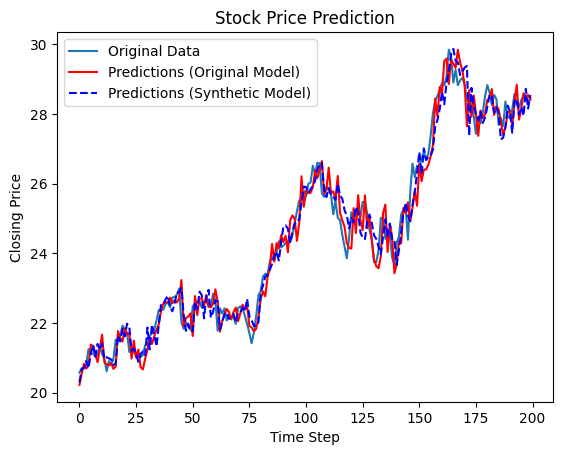

In [13]:
# Visualize predictions
plt.figure()
plt.plot(true_y[100:300], label='Original Data')
plt.plot(pred_y_ori[100:300], label='Predictions (Original Model)', linestyle='-', color='r')
plt.plot(pred_y_ori_fake[100:300], label='Predictions (Synthetic Model)', linestyle='--', color='b')
plt.legend()
plt.title("Stock Price Prediction")
plt.xlabel("Time Step")
plt.ylabel("Closing Price")
plt.show()


## additional training

In [14]:
# # Generate adversarial data
# ori_data = torch.from_numpy(np.load('output/stock_ground_truth_data_24_train.npy')).to(device)
# adv_data = diffusion_adversarial.generate_adversarial(ori_data,
#                                                       predictor=model_ori_fake.to(device))

# # Concatenate adversarial data with original data for training
# combined_data = torch.cat([ori_data, adv_data], dim=0)
# from torch.utils.data import DataLoader
# combined_loader = DataLoader(adv_data, batch_size=128, shuffle=True)

In [15]:
# import gc

# # At the beginning or end of training
# torch.cuda.empty_cache()
# gc.collect()


In [16]:
# train_model(model_ori_fake, combined_loader, criterion_ori_fake, optimizer_ori_fake, num_epochs=250, description="Synthetic + Original")
# train_model(model_fake, ori_fake_dl, criterion_fake, optimizer_fake, num_epochs=250, description="Synthetic")
# train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=250, description="Original")

In [17]:
# loss_ori_l1, loss_ori_l2, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
# loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
# loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)

# print(f"Original Model : \t L1 loss: {loss_ori_l1:0.5f} \t L2 Loss : {loss_ori_l2:0.5f} \t MAPE loss : {mape_loss_ori:0.5f} ")
# print(f"Fake Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
# print(f"OriFake Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")


In [18]:
for i in range(50):
    # Generate adversarial data
    ori_data = torch.from_numpy(np.load('output/stock_ground_truth_data_24_train.npy')).to(device)
    adv_data = diffusion_adversarial.generate_adversarial(ori_data,
                                                        predictor=model_ori_fake.to(device))

    # Concatenate adversarial data with original data for training
    combined_data = torch.cat([ori_data, adv_data], dim=0)
    combined_loader = DataLoader(adv_data, batch_size=128, shuffle=True)
    
    torch.cuda.empty_cache()
    gc.collect()
    
    train_model(model_ori_fake, combined_loader, criterion_ori_fake, optimizer_ori_fake, num_epochs=500, description="AdvSyn + Original")
    # train_model(model_fake, ori_fake_dl, criterion_fake, optimizer_fake, num_epochs=500, description="Synthetic")
    # train_model(model_ori, ori_dl, criterion_ori, optimizer_ori, num_epochs=500, description="Original")
    
    # loss_ori_l1, loss_ori_l2, mape_loss_ori, pred_y_ori, true_y = evaluate_model(model_ori, test_loader)
    # loss_fake_l1, loss_fake_l2, mape_loss_fake, pred_y_fake, _ = evaluate_model(model_fake, test_loader)
    loss_ori_fake_l1, loss_ori_fake_l2, mape_loss_ori_fake, pred_y_ori_fake, _ = evaluate_model(model_ori_fake, test_loader)

    # print(f"Original Model : \t L1 loss: {loss_ori_l1:0.5f} \t L2 Loss : {loss_ori_l2:0.5f} \t MAPE loss : {mape_loss_ori:0.5f} ")
    # print(f"Fake Model : \t L1 loss: {loss_fake_l1:0.5f} \t L2 Loss : {loss_fake_l2:0.5f} \t MAPE loss : {mape_loss_fake:0.5f} ")
    print(f"OriFake Model : \t L1 loss: {loss_ori_fake_l1:0.5f} \t L2 Loss : {loss_ori_fake_l2:0.5f} \t MAPE loss : {mape_loss_ori_fake:0.5f} ")



AdvSyn + Original loss: 0.022081: 100%|██████████| 500/500 [00:11<00:00, 42.34it/s]


OriFake Model : 	 L1 loss: 0.59386 	 L2 Loss : 0.66307 	 MAPE loss : 0.01641 


AdvSyn + Original loss: 0.019209:  17%|█▋        | 84/500 [00:01<00:09, 42.52it/s]


KeyboardInterrupt: 